In [1]:
# cnn_model.ipynb

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/mura_modules')

import numpy as np
from cnn_model import build_cnn_model
from metrics import get_binary_metrics
from config import BATCH_SIZE, IMAGE_SIZE, NUM_CLASSES_BINARY, NUM_CLASSES_BODYPART
from data_generator import MuraSequence
from plot_utils import plot_training_history


In [3]:
# Step 2: Load cached train & validation data
train_data = np.load('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/mura_train_data.npz')
val_data = np.load('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/mura_valid_data.npz')

X_train = train_data['images']
y_bin_train = train_data['labels_binary']
y_part_train = train_data['labels_bodypart']

X_val = val_data['images']
y_bin_val = val_data['labels_binary']
y_part_val = val_data['labels_bodypart']

print(f"Train: {X_train.shape=}, {y_bin_train.shape=}, {y_part_train.shape=}")
print(f"Val:   {X_val.shape=}, {y_bin_val.shape=}, {y_part_val.shape=}")



Train: X_train.shape=(36805, 224, 224, 3), y_bin_train.shape=(36805,), y_part_train.shape=(36805, 1)
Val:   X_val.shape=(3193, 224, 224, 3), y_bin_val.shape=(3193,), y_part_val.shape=(3193, 1)


In [5]:
model = build_cnn_model(
    input_shape=(224, 224, 3),  # Match the cached image size
    num_classes_binary=NUM_CLASSES_BINARY,
    num_classes_bodypart=NUM_CLASSES_BODYPART
)


In [6]:
# Compute class weights for binary classification (normal/abnormal)
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Compute binary class weights
binary_class_weights_arr = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_bin_train
)
print("Sample weights shape:", binary_class_weights_arr.shape)

# Define callbacks
callbacks = [
    ModelCheckpoint("cnn_model_best.keras", monitor="val_loss", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

# Sample weights (apply only to binary task, uniform weights to bodypart)
sample_weights = [
    binary_class_weights_arr,                     # for binary_output
    np.ones(len(y_part_train))                   # for bodypart_output
]

# Train model
history = model.fit(
    X_train, [y_bin_train, y_part_train],
    validation_data=(X_val, [y_bin_val, y_part_val]),
    batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=callbacks,
    sample_weight=sample_weights,
    verbose=1
)

Sample weights shape: (36805,)
Epoch 1/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - binary_output_accuracy: 0.5705 - binary_output_loss: 1.7157 - bodypart_output_accuracy: 0.9867 - bodypart_output_loss: 0.0924 - loss: 1.8081 - val_binary_output_accuracy: 0.5731 - val_binary_output_loss: 0.6853 - val_bodypart_output_accuracy: 0.9997 - val_bodypart_output_loss: 7.7209e-04 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 2/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - binary_output_accuracy: 0.6229 - binary_output_loss: 0.6429 - bodypart_output_accuracy: 0.9999 - bodypart_output_loss: 2.5899e-04 - loss: 0.6432 - val_binary_output_accuracy: 0.5982 - val_binary_output_loss: 0.7037 - val_bodypart_output_accuracy: 1.0000 - val_bodypart_output_loss: 8.1956e-09 - val_loss: 0.7042 - learning_rate: 0.0010
Epoch 3/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - binary_output_accuracy: 0.6516 - binary_output_loss: 0.6212 - bodypart_output_accuracy: 1.0000 - bodypart_output_loss: 3.5693e-04 - l

In [7]:
# Evaluate binary classification (normal/abnormal)
y_pred_probs, _ = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report
print("=== Binary Classification Report (Normal/Abnormal) ===")
print(classification_report(y_bin_val, y_pred, target_names=["Normal", "Abnormal"]))

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
=== Binary Classification Report (Normal/Abnormal) ===
              precision    recall  f1-score   support

      Normal       0.64      0.73      0.69      1667
    Abnormal       0.66      0.56      0.60      1526

    accuracy                           0.65      3193
   macro avg       0.65      0.64      0.64      3193
weighted avg       0.65      0.65      0.65      3193



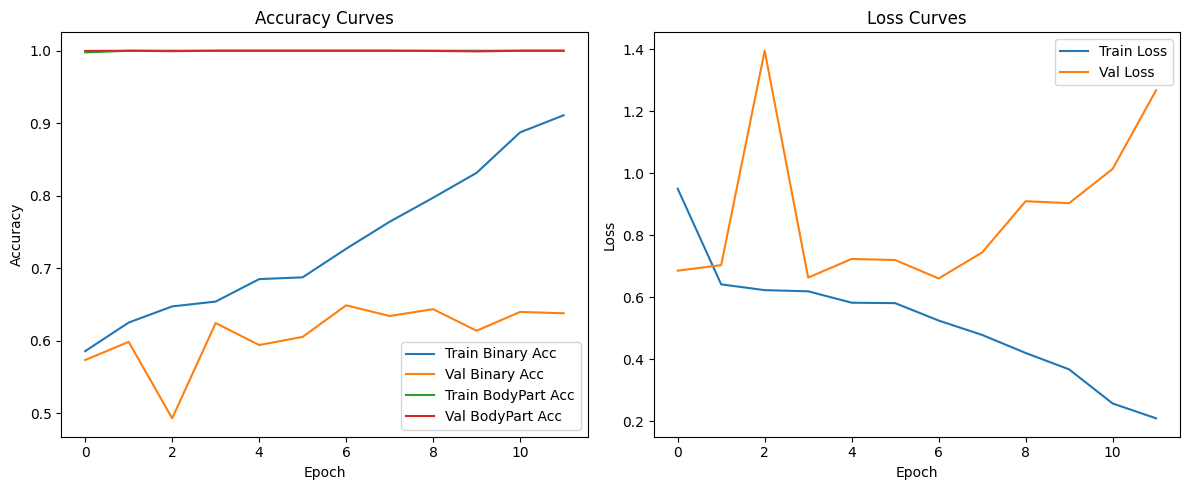

In [11]:
# Step 6: Plot training history
plot_training_history(history)